In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
from yellowbrick.text import FreqDistVisualizer
from pathlib import Path
nlp=spacy.load('en_core_web_sm')
from textblob import TextBlob, Word, Blobber

from sb_utils import save_file


from surprise import accuracy, Dataset, SVD, NormalPredictor, BaselineOnly
from surprise import Reader
from surprise.model_selection import cross_validate, train_test_split, LeaveOneOut, ShuffleSplit 
from surprise.model_selection import RandomizedSearchCV,GridSearchCV
from surprise import KNNBasic,  KNNWithMeans, KNNBaseline
from surprise.model_selection import KFold

from sklearn.model_selection import train_test_split as tts1
import datetime
import math

In [2]:
#full dataset
#wine_df2 = pd.read_csv('C:/Users/jwatki8/Documents/Data Science Program information/Capstone project 3/data/wine_df.csv')

In [2]:
wine_df = pd.read_csv('C:/Users/jwatki8/Documents/Data Science Program information/Capstone project 3/data/wine_df_S.csv')

In [3]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 50 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   RatingID                                150000 non-null  int64  
 1   UserID                                  150000 non-null  int64  
 2   WineID                                  150000 non-null  int64  
 3   Vintage                                 150000 non-null  object 
 4   Rating                                  150000 non-null  float64
 5   Date                                    150000 non-null  object 
 6   rating_mean                             150000 non-null  float64
 7   rater_count                             150000 non-null  int64  
 8   rater_mean                              150000 non-null  float64
 9   WineName                                150000 non-null  object 
 10  Type                                    1500

Since our recommender system will be based on user ratings of wine, let’s start by parsing out the user id, wine id and rating.

In [4]:
rec_base=wine_df[['UserID', 'WineID','Rating']]

In [5]:
rec_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   UserID  150000 non-null  int64  
 1   WineID  150000 non-null  int64  
 2   Rating  150000 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 3.4 MB


Next I will create the surprise data set to cross-validate our models on as well as create an anti-set to run predictions on later.

In [6]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rec_base[['UserID', 'WineID', 'Rating']], reader)
anti_set = data.build_full_trainset().build_anti_testset()

I will start with a Normal Predictor model to examine a baseline RMSE for our dataset.

### Normal Predictor Model

In [7]:
algo = NormalPredictor()
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=3,verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9052  0.9028  0.9048  0.9043  0.0010  
MAE (testset)     0.7173  0.7173  0.7183  0.7176  0.0005  
Fit time          0.16    0.19    0.19    0.18    0.01    
Test time         0.55    0.55    0.35    0.48    0.09    


{'test_rmse': array([0.9052443 , 0.90283635, 0.90477309]),
 'test_mae': array([0.71727643, 0.71726266, 0.71826113]),
 'fit_time': (0.16220426559448242, 0.19246172904968262, 0.19398999214172363),
 'test_time': (0.5460760593414307, 0.5487442016601562, 0.3549072742462158)}

As expected it looks like our mean RMSE (0.906) is fairly high for a rating scale of 1-5. Let’s try out another model.

### SVD Model

In [8]:
algo2 = SVD()
cross_validate(algo2, data, measures=["RMSE", "MAE"], cv=3,verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4895  0.4888  0.4864  0.4882  0.0013  
MAE (testset)     0.3592  0.3591  0.3582  0.3588  0.0005  
Fit time          1.42    1.39    1.39    1.40    0.01    
Test time         0.65    0.61    0.37    0.54    0.12    


{'test_rmse': array([0.48945722, 0.4887702 , 0.48639002]),
 'test_mae': array([0.35923702, 0.3591221 , 0.35816188]),
 'fit_time': (1.4193427562713623, 1.3934082984924316, 1.3869843482971191),
 'test_time': (0.6450481414794922, 0.6115481853485107, 0.36951470375061035)}

The SVD model gives us a much better mean RMSE of 0.488. Next I will test out some of the KNN models.

### KNN With Means Model

In [9]:
algo3 = KNNWithMeans()
cross_validate(algo3, data, measures=["RMSE", "MAE"], cv=3,verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.5236  0.5292  0.5202  0.5244  0.0037  
MAE (testset)     0.3889  0.3921  0.3868  0.3893  0.0022  
Fit time          5.14    5.62    5.87    5.54    0.30    
Test time         20.84   20.54   19.79   20.39   0.44    


{'test_rmse': array([0.52363883, 0.52919261, 0.52023413]),
 'test_mae': array([0.38888393, 0.39208587, 0.38683604]),
 'fit_time': (5.1357855796813965, 5.615605115890503, 5.866661310195923),
 'test_time': (20.841920614242554, 20.53688144683838, 19.79275131225586)}

The KNNWithMeans model has a higher mean RMSE than both of the previous models. The test time is also much longer than the both of the previous models. 

### KNN Baseline Model

In [10]:
algo4 = KNNBaseline()
cross_validate(algo4, data, measures=["RMSE", "MAE"], cv=3,verbose=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4888  0.4873  0.4845  0.4869  0.0018  
MAE (testset)     0.3572  0.3557  0.3561  0.3563  0.0006  
Fit time          5.65    5.90    5.78    5.77    0.10    
Test time         21.14   21.49   21.80   21.48   0.27    


{'test_rmse': array([0.48878057, 0.48729374, 0.4845407 ]),
 'test_mae': array([0.35718014, 0.35568927, 0.35606512]),
 'fit_time': (5.648054122924805, 5.895566940307617, 5.7778480052948),
 'test_time': (21.135846376419067, 21.487884998321533, 21.80464506149292)}

The KNNBaseline model seems to have the best mean RMSE at 0.486. It also has the longest mean fit and test time of all of our models. 

From the results outputted from testing different models on our data, I think it would be wise to move forward with fine tuning and applying both the KNNBaseline model as well as our SVD model. Even though the KNNBaseline model technically has the best mean RMSE, The SVD model has an RMSE that is very close and also would save a lot of test and fit time. I think it would be worth comparing the predictions for both models to find out if we can save time in the long run.

First let’s run a grid search for the best hyperparameters for our KNNBaseline Model.

In [ ]:
#Gridsearch for KNNBaseline

In [12]:
param_gridKNNB = {'n_epochs': [5, 10, 15],
        'lr_all': [0.002, 0.005],
        'reg_all': [0.4, 0.6, 0.8]
        }

gsKNNB = GridSearchCV(KNNBaseline, param_gridKNNB, measures=['rmse'], cv=3)

gsKNNB.fit(data)

print('Best RMSE:', gsKNNB.best_score['rmse'], gsKNNB.best_params['rmse'])

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

It looks like the best parameters for this model are as follows:
{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4}


Now let’s find the best parameters for the SVD model.

In [ ]:
#GridSearch for SVD

In [13]:
param_grid = {'n_epochs': [5, 10, 15],
        'lr_all': [0.002, 0.005],
        'reg_all': [0.4, 0.6, 0.8]
        }

gs_SVD = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs_SVD.fit(data)

print('Best RMSE:', gs_SVD.best_score['rmse'], gs_SVD.best_params['rmse'])

Best RMSE: 0.5019710396266478 {'n_epochs': 15, 'lr_all': 0.005, 'reg_all': 0.4}


The best parameters for the SVD model are as follows:
{'n_epochs': 15, 'lr_all': 0.005, 'reg_all': 0.4}

Next I will create the traintest split for the data.

In [14]:
#update to surprise traintest set to make predictions
trainset, testset = train_test_split(data, test_size=0.25, random_state=22)

To apply the model and get predictions, I will create a dataframe that will display the user, wine the actual rating and the predicted rating from our model.

In [16]:
#KNNBaseline
predictions = KNNBaseline(bsl_options=gsKNNB.best_params['rmse']).fit(trainset).test(testset)
KNN_Predictions = pd.DataFrame(predictions, columns=['UserID', 'WineID', 'Real_Rating', 'Estimated_Rating', 'details'])
KNN_Predictions.drop(['details'], axis=1, inplace=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [17]:
#SVD
predictions = SVD(n_epochs=15, lr_all=0.005, reg_all=0.4).fit(trainset).test(testset)
SVD_Predictions = pd.DataFrame(predictions, columns=['UserID', 'WineID', 'Real_Rating', 'Estimated_Rating', 'details'])
SVD_Predictions.drop(['details'], axis=1, inplace=True)

Because the actual ratings between 1 and 5 all have either .0 or .5 decimals, I need to create a function that will round the predicted results to .0 or .5. This will ensure that the predictions are actual possible ratings.

In [18]:
def halfrounder(x):
    frac, whole = math.modf(x)
    if frac > 0.7499999:
        a = 1
    elif frac < 0.25:
        a = 0
    else:
        a = 0.5
    return whole + a

In [19]:
#knnbaseline
KNN_Predictions['Estimation_Rounded'] = KNN_Predictions.apply(lambda row: halfrounder(row.Estimated_Rating), axis=1)

In [20]:
#svd
SVD_Predictions['Estimation_Rounded'] = SVD_Predictions.apply(lambda row: halfrounder(row.Estimated_Rating), axis=1)


Now we have a column in our predictions data frame that includes the rounded predictions. Let’s take a look at our results.

In [21]:
KNN_Predictions.head()

,UserID,WineID,Real_Rating,Estimated_Rating,Estimation_Rounded
0,1971360,111475,4.0,4.297177,4.5
1,1358888,193487,3.0,3.284433,3.5
2,1222064,155623,3.0,2.885143,3.0
3,1095942,113730,4.5,4.218465,4.0
4,1006401,111434,4.0,4.336163,4.5


In [22]:
KNN_Predictions.tail()

,UserID,WineID,Real_Rating,Estimated_Rating,Estimation_Rounded
37495,1959228,162507,4.0,3.818995,4.0
37496,1395496,135859,3.5,3.632870,3.5
37497,1303827,167429,3.5,4.189447,4.0
37498,1181889,101610,3.0,3.632358,3.5
37499,1014224,179034,3.0,3.903756,4.0


To get a better idea of the amount of accurate predictions we have, I want to create a subset of the dataframe that only includes the rows where the actual user rating and the predicted user ratings match.

In [23]:
Perfect_KNN=KNN_Predictions.query('Real_Rating == Estimation_Rounded')


In [24]:
Perfect_KNN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17511 entries, 2 to 37496
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   UserID              17511 non-null  int64  
 1   WineID              17511 non-null  int64  
 2   Real_Rating         17511 non-null  float64
 3   Estimated_Rating    17511 non-null  float64
 4   Estimation_Rounded  17511 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 820.8 KB


In [25]:
Perfect_KNN.head()

,UserID,WineID,Real_Rating,Estimated_Rating,Estimation_Rounded
2,1222064,155623,3.0,2.885143,3.0
5,1215266,111429,4.0,4.067975,4.0
6,1210984,135885,4.0,3.967138,4.0
7,1064790,113344,4.0,4.068471,4.0
10,1387564,167530,3.5,3.484070,3.5


For the KNNBaseline model we have 17511 accurate predicted ratings. Let’s also examine the distribution of ratings within our accurate predictions dataset.

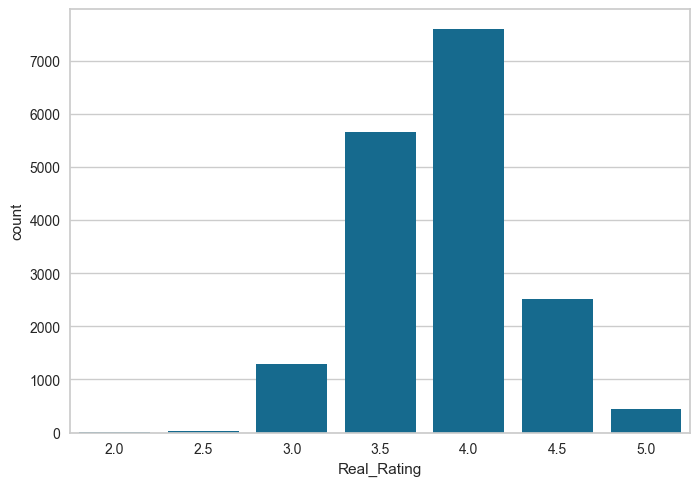

In [27]:
sns.countplot(data=Perfect_KNN, x='Real_Rating')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


The most represented rating in this subset is 4.0 followed by 3.5. Is this representative of the distribution of the whole dataset?

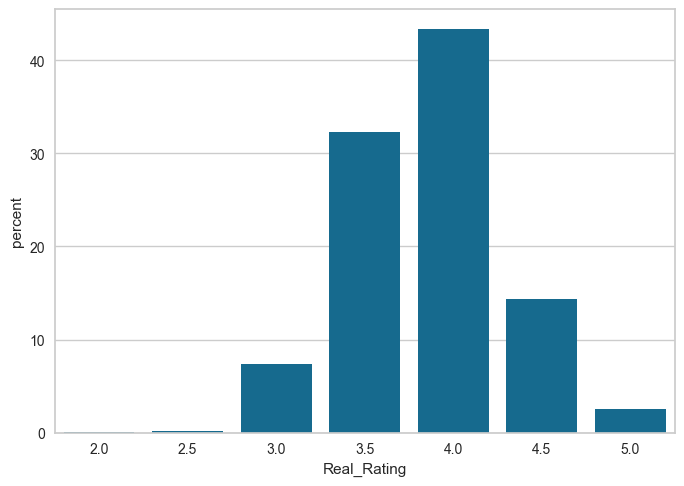

In [26]:
sns.countplot(data=Perfect_KNN, x='Real_Rating', stat='percent')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


The percent distribution shows that our accurate results distribution is similar to that of the entire dataset which had just under 40% of the ratings as 4.0.

Let’s take a look at our predictions with the SVD model.

In [28]:
Perfect_SVD=SVD_Predictions.query('Real_Rating == Estimation_Rounded')

In [29]:
Perfect_SVD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16744 entries, 0 to 37496
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   UserID              16744 non-null  int64  
 1   WineID              16744 non-null  int64  
 2   Real_Rating         16744 non-null  float64
 3   Estimated_Rating    16744 non-null  float64
 4   Estimation_Rounded  16744 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 784.9 KB


In [30]:
Perfect_SVD.head()

,UserID,WineID,Real_Rating,Estimated_Rating,Estimation_Rounded
0,1971360,111475,4.0,4.230864,4.0
2,1222064,155623,3.0,3.059422,3.0
5,1215266,111429,4.0,4.078885,4.0
6,1210984,135885,4.0,3.835609,4.0
7,1064790,113344,4.0,3.963171,4.0


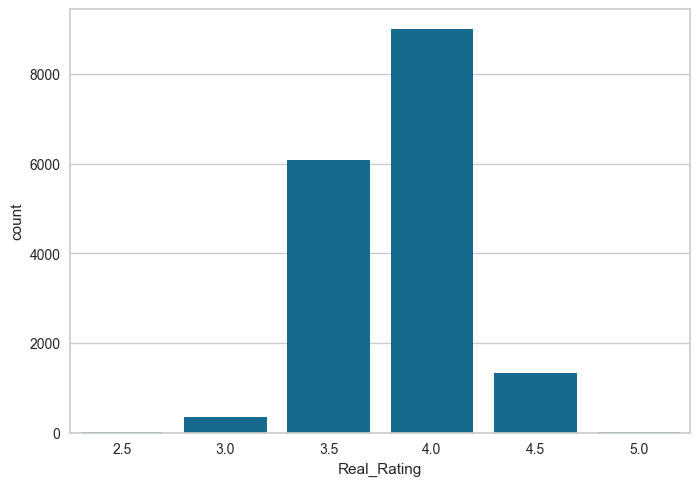

In [31]:
sns.countplot(data=Perfect_SVD, x='Real_Rating')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

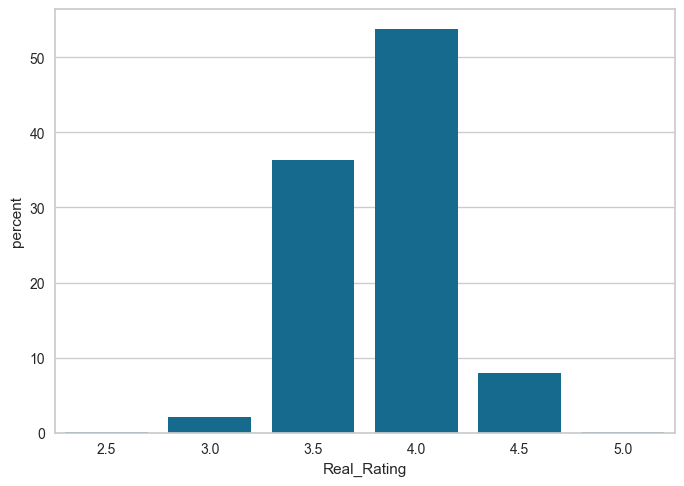

In [32]:
sns.countplot(data=Perfect_SVD, x='Real_Rating', stat='percent')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

The number of accurate predictions for the SVD model are lower that the KNNBaseline at 16744. The rating distribution for this model is very similar to the KNNBaseline model with the top represented rating being 4.0.

### Conclusions

After using each model to create predictions it looks like the KNNBaseline model produces better results than the SVD model. The KNN baseline produces accurate predictions for 11.6% of the user ratings while the SVD model produces accurate predictions for 11.2 percent of the ratings. If the expense of time was a large factor for producing a final model, it could be argued that the SVD model could still be used. Considering the fact that both models give us accurate predictions of around 11% the time gained could be worth it to our stakeholders.